<a href="https://colab.research.google.com/github/Vicente836/Practica-Ihealth/blob/S2/Algoritmo_ATLAS_variando_n_modos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación datos test

In [1]:
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

--2024-12-13 15:09:42--  https://fem-on-colab.github.io/releases/gmsh-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3497 (3.4K) [application/x-sh]
Saving to: ‘/tmp/gmsh-install.sh’

/tmp/gmsh-install.s 100%[===================>]   3.42K  --.-KB/s    in 0.001s  

2024-12-13 15:09:42 (3.21 MB/s) - ‘/tmp/gmsh-install.sh’ saved [3497/3497]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ GMSH_INSTALLED=/usr/local/share/fem-on-colab/gmsh.installed
+ [[ ! -f /usr/local/share/fem-on-colab/gmsh.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/bc474259/releases/h5py-install.sh
+ [[ https://gith

In [2]:
!pip install meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.2 MB/s eta 0:00:00


In [3]:
!pip install ukb-atlas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 2.3 MB/s eta 0:00:00


In [4]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123633 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libgl1-mesa-glx:amd64.
Preparing to unpack .../1-libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../2-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../3-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../4-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselec

In [5]:
import pyvista
pyvista.set_jupyter_backend('static')
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

In [18]:
import pyvista as pv
import os
#import tetgen
import numpy as np
import random
import matplotlib.pyplot as plt

# Algoritmo ICP con modelo del atlas con mínimos cuadrados

---



In [20]:
from scipy.spatial import cKDTree
from numpy.linalg import lstsq
import h5py as h5

In [23]:
pc = h5.File('UKBRVLV.h5', 'r')
f = 'connectivity.txt'
conn = np.loadtxt(f, dtype=int)
alpha_real = np.array([0.0, 0.0, -1.5, 0.0, 0.0])

# Genera una malla con los puntos obtenidos del atlas para ciertos parametros de alpha
def create_heart_ATLAS(alpha):
  n = len(alpha)
  S = np.transpose(pc['MU']) + sum( alpha[i]*np.sqrt(pc['LATENT'][0,i])*pc['COEFF'][i,:] for i in range(n))
  N = S.shape[1] // 2
  points_ = np.reshape(S[0,:N], (-1,3))
  unwanted_nodes = (5630, 5655, 5696, 5729)
  points = np.delete(points_, unwanted_nodes, axis=0)
  faces = (np.c_[3*np.ones(conn.shape[0]),conn]).astype("int32").flatten()
  celltypes = np.full(conn.shape[0], fill_value=pv.CellType.TRIANGLE, dtype=np.uint8)
  mesh = pv.UnstructuredGrid(faces, celltypes, points)
  return mesh

def loss(alpha, data_points):
  X_points = create_heart_ATLAS(alpha).points
  tree = cKDTree(X_points)
  idx_cp = tree.query(data_points)[1]
  return 0.5*np.mean(np.sum((X_points[idx_cp]-data_points)**2, axis = 1))

def lstsq_ATLAS(alpha, data_points):
  # obtencion closest points en el modelo definido por alpha
  n = len(alpha)
  X_points = create_heart_ATLAS(alpha).points
  tree = cKDTree(X_points)
  idx_cp = tree.query(data_points)[1]

  # procesamiento para tener las coordenadas de los vectores propios correspondientes a los cp
  N = data_points.shape[0]
  valp = pc['LATENT'][0,0:n]
  vecp = pc['COEFF'][0:n,:]
  k = vecp[0].shape[0] // 2
  vecp_ED = vecp[:,:k]
  vecp_ED_resh= np.array([np.reshape(v, (-1,3)) for v in vecp_ED ])
  vecp_ED_cp = (vecp_ED_resh[:, idx_cp]).reshape(n,-1)
  vecp_ED_cp_valp = np.array([np.sqrt(valp[i])*vecp_ED_cp[i] for i in range(n)] ) # multiplicamos por valores coeficientes 'latent'
  # coordenadas del modelo promedio asociadas a los cp
  mu = pc['MU']
  mu_ED = np.reshape(mu[:k], (-1,3))
  mu_ED_cp = mu_ED[idx_cp]
  alpha_, _, _, _ = lstsq(vecp_ED_cp_valp.T, (data_points-mu_ED_cp).flatten(), rcond = False)
  return alpha_

#####################################################################

#####################################################################

# algorithm that optimize parameters for PCA
def ATLAS_ICP_LS(data_points, n_modes = 5, N_iter=5):
  # start with mean shape of the PCA
  alpha_ = np.zeros(n_modes)
  print('Valor de alpha inicial: ' + str(alpha_))
  loss_rec = []
  loss_real_rec = []
  for i in range(N_iter):
    alpha_  = lstsq_ATLAS(alpha_, data_points)
    loss_ = loss(alpha_, data_points)
    loss_rec.append(loss_)
    opt_points = create_heart_ATLAS(alpha_).points
    loss_real = loss(alpha_real, opt_points)
    loss_real_rec.append(loss_real)
  print('Valor de alpha final: ' + str(alpha_))
  print('Loss mínimo:' + str(min(loss_rec)))
  return alpha_, loss_rec, loss_real_rec

## Variación con gradiente descenediente

In [11]:
def gradloss(alpha, data_points):
  n = len(alpha)
  X_points = create_heart_ATLAS(alpha).points
  tree = cKDTree(X_points)
  idx_cp = tree.query(data_points)[1]
  N = data_points.shape[0]
  valp = pc['LATENT'][0,0:n]
  vecp = pc['COEFF'][0:n,:]
  k = vecp[0].shape[0] // 2
  vecp_ED = vecp[:,:k]
  vecp_ED_resh= np.array([np.reshape(v, (-1,3)) for v in vecp_ED ])
  grad = np.zeros(n)
  for i in range(n):
    grad[i] = (1/N)*np.dot((X_points[idx_cp] - data_points).flatten(), ((vecp_ED_resh[i])[idx_cp]).flatten()*np.sqrt(valp[i]))
  return grad

# algorithm that optimize parameters for PCA
def ATLAS_ICP_GD(data_points, n_modes = 5, N_iter=5, lr=0.05):
  # start with mean shape of the PCA
  alpha_ = np.zeros(n_modes)
  print('Valor de alpha inicial: ' + str(alpha_))
  loss_rec = []
  loss_real_rec = []
  for i in range(N_iter):
    grad = gradloss(alpha_, data_points)
    alpha_ = alpha_ - lr * grad
    loss_ = loss(alpha_, data_points)
    loss_rec.append(loss_)
    opt_points = create_heart_ATLAS(alpha_).points
    loss_real = loss(alpha_real, opt_points)
    loss_real_rec.append(loss_real)
  print('Valor de alpha final: ' + str(alpha_))
  print('Loss mínimo:' + str(min(loss_rec)))
  return alpha_, loss_rec, loss_real_rec

In [12]:
# funcion para generar nube de puntos a partir de array de slices para visualizar datos
def point_cloud(slices):
  point_cloud = []
  for i, sl in enumerate(slices):
    points = sl.points
    point_cloud.extend(points)
  return pv.PolyData(point_cloud)

# Test del algoritmo

In [13]:
# Modelo original por predecir
mesh_real = create_heart_ATLAS(alpha_real)

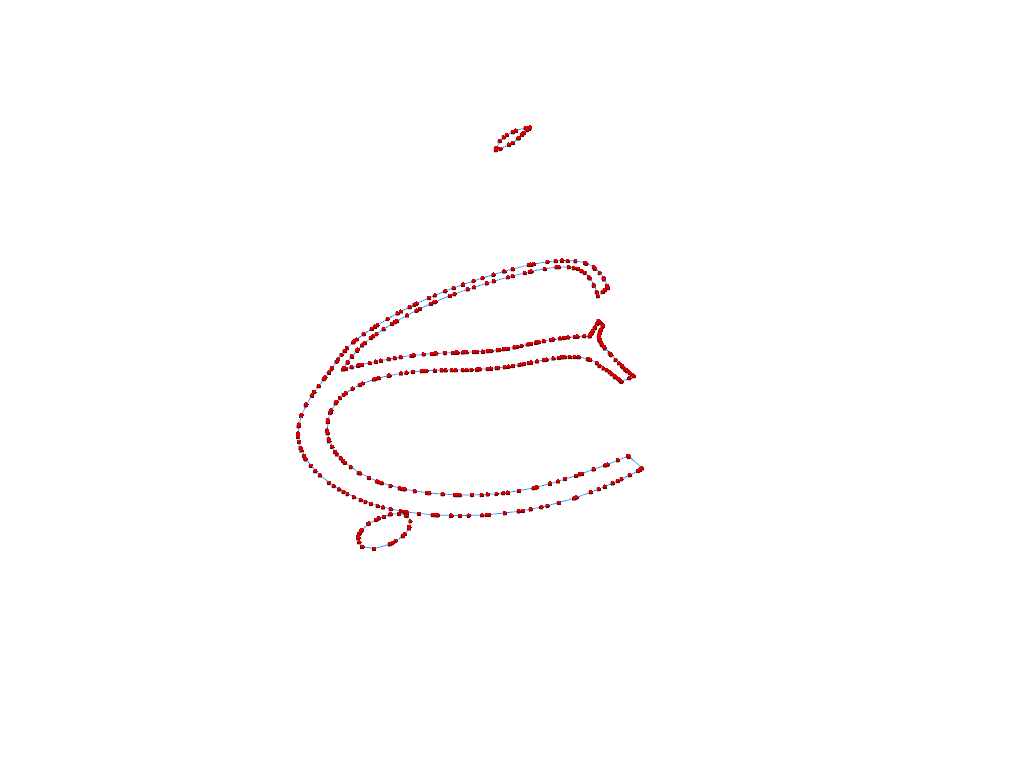

In [14]:
# Creación de datos de entrenamiento
slices = mesh_real.slice_along_axis(n=3, axis="z")
#slices = mesh_real.slice_orthogonal()
data = point_cloud(slices)
p = pv.Plotter()
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(slices, color = 'dodgerblue', show_edges = True)
p.show()

In [24]:
data_points = data.points
modes = 5
num_iter = 100
print('// Algoritmo con mínimos cuadrados //')
alpha_opt, loss_rec, loss_real_rec = ATLAS_ICP_LS(data_points, n_modes=modes, N_iter=num_iter)
print('Valor de alpha real = ' + str(alpha_real))
opt_points = create_heart_ATLAS(alpha_opt).points
err_real = loss(alpha_real, opt_points)
print('Error real: ' + str(err_real))

// Algoritmo con mínimos cuadrados //
Valor de alpha inicial: [0. 0. 0. 0. 0.]
Valor de alpha final: [ 0.07770768 -0.90160934 -0.27375175 -0.2635501  -1.0481866 ]
Loss mínimo:0.9481537485903258
Valor de alpha real = [ 0.   0.  -1.5  0.   0. ]
Error real: 1.0254641896281083


In [16]:
print('// Algoritmo con gradiente descendiente //')
alpha_opt_gd, loss_rec_gd, loss_real_rec_gd = ATLAS_ICP_GD(data_points, n_modes=modes, N_iter=num_iter, lr=0.2)
print('Valor de alpha real = ' + str(alpha_real))
opt_points_gd = create_heart_ATLAS(alpha_opt_gd).points
err_real_gd = loss(alpha_real, opt_points_gd)
print('Error real: ' + str(err_real_gd))

// Algoritmo con gradiente descendiente //
Valor de alpha inicial: [0. 0. 0. 0. 0.]
Valor de alpha final: [ 0.03140143 -0.15083343 -1.37028931 -0.09564397 -0.02475816]
Loss mínimo:0.6845000627091443
Valor de alpha real = [ 0.   0.  -1.5  0.   0. ]
Error real: 0.01872429625248341


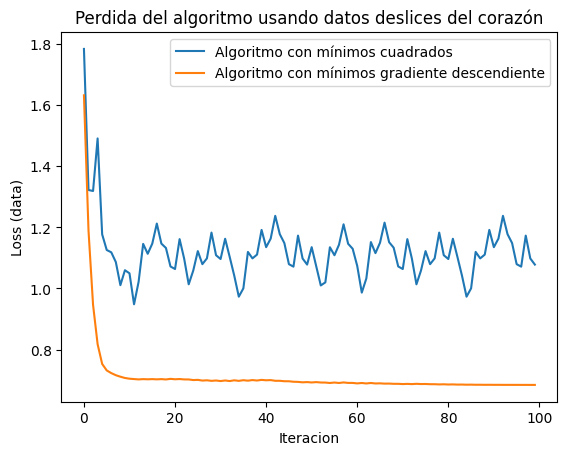

In [25]:
plt.plot(range(num_iter), loss_rec, label = 'Algoritmo con mínimos cuadrados')
plt.plot(range(num_iter), loss_rec_gd, label = 'Algoritmo con mínimos gradiente descendiente')
plt.title('Perdida del algoritmo usando datos deslices del corazón')
plt.xlabel('Iteracion')
plt.ylabel('Loss (data)')
plt.legend()
plt.show()

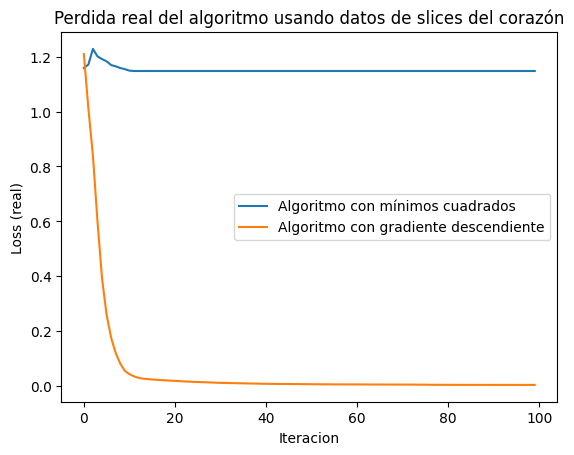

In [173]:
plt.plot(range(num_iter), loss_real_rec, label = 'Algoritmo con mínimos cuadrados')
plt.plot(range(num_iter), loss_real_rec_gd, label = 'Algoritmo con gradiente descendiente')
plt.title('Perdida real del algoritmo usando datos de slices del corazón')
plt.xlabel('Iteracion')
plt.ylabel('Loss (real)')
plt.legend()
plt.show()

## Comparación final

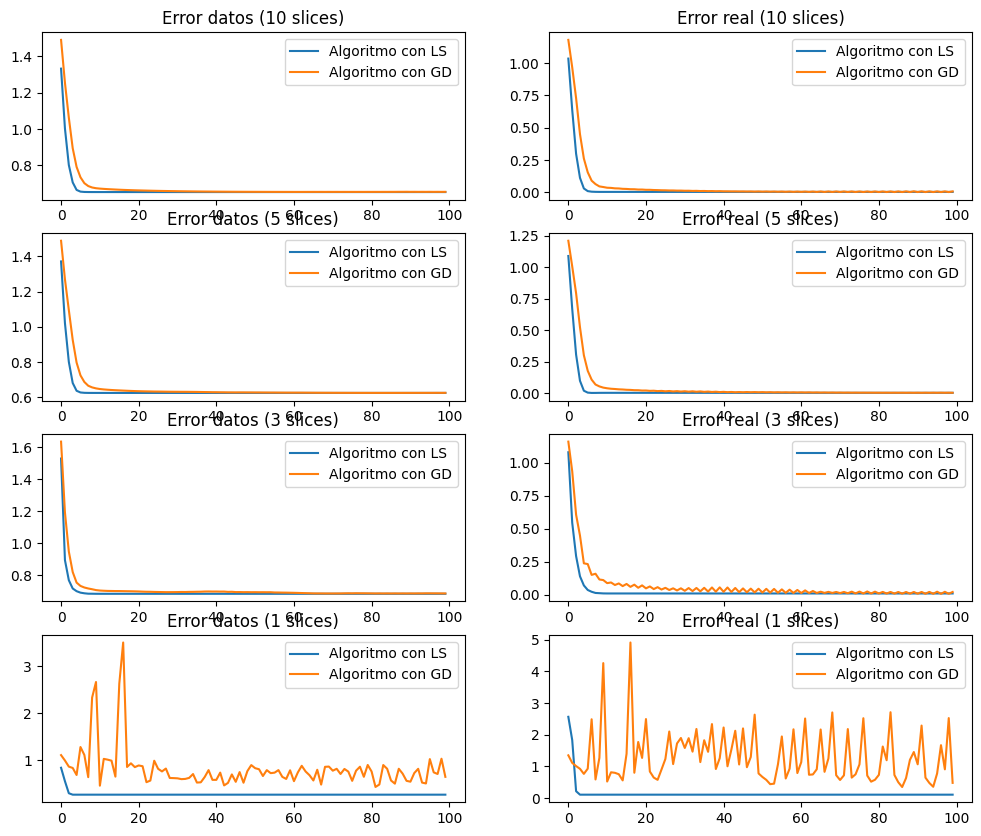

In [ ]:
ran = range(num_iter)
fig, axs = plt.subplots(4, 2)
fig.set_size_inches((12, 10))

axs[0, 0].plot(ran, loss_rec_ls_10, label = 'Algoritmo con LS' )
axs[0, 0].plot(ran, loss_rec_gd_10, label = 'Algoritmo con GD')
axs[0, 0].legend()
axs[0, 0].set_title('Error datos (10 slices)')
axs[0, 1].plot(ran, loss_real_rec_ls_10, label = 'Algoritmo con LS' )
axs[0, 1].plot(ran, loss_real_rec_gd_10, label = 'Algoritmo con GD')
axs[0, 1].set_title('Error real (10 slices)')
axs[0, 1].legend()
axs[1, 0].plot(ran, loss_rec_ls_5, label = 'Algoritmo con LS' )
axs[1, 0].plot(ran, loss_rec_gd_5, label = 'Algoritmo con GD')
axs[1, 0].legend()
axs[1, 0].set_title('Error datos (5 slices)')
axs[1, 1].plot(ran, loss_real_rec_ls_5, label = 'Algoritmo con LS' )
axs[1, 1].plot(ran, loss_real_rec_gd_5, label = 'Algoritmo con GD')
axs[1, 1].set_title('Error real (5 slices)')
axs[1, 1].legend()
axs[2, 0].plot(ran, loss_rec_ls_3, label = 'Algoritmo con LS' )
axs[2, 0].plot(ran, loss_rec_gd_3, label = 'Algoritmo con GD')
axs[2, 0].legend()
axs[2, 0].set_title('Error datos (3 slices)')
axs[2, 1].plot(ran, loss_real_rec_ls_3, label = 'Algoritmo con LS' )
axs[2, 1].plot(ran, loss_real_rec_gd_3, label = 'Algoritmo con GD')
axs[2, 1].set_title('Error real (3 slices)')
axs[2, 1].legend()
axs[3, 0].plot(ran, loss_rec_ls_1, label = 'Algoritmo con LS' )
axs[3, 0].plot(ran, loss_rec_gd_1, label = 'Algoritmo con GD')
axs[3, 0].legend()
axs[3, 0].set_title('Error datos (1 slices)')
axs[3, 1].plot(ran, loss_real_rec_ls_1, label = 'Algoritmo con LS' )
axs[3, 1].plot(ran, loss_real_rec_gd_1, label = 'Algoritmo con GD')
axs[3, 1].set_title('Error real (1 slices)')
axs[3, 1].legend()


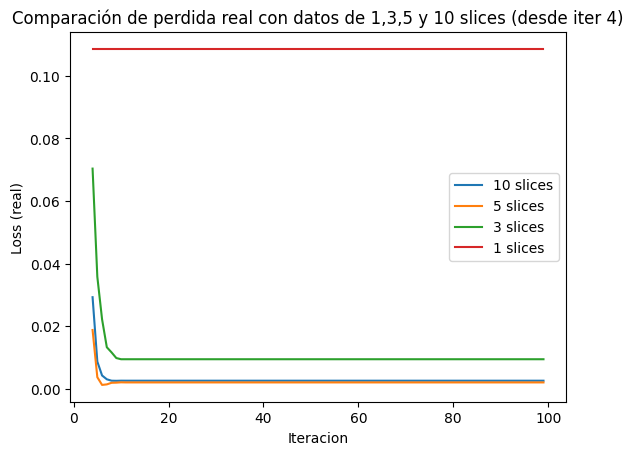

In [ ]:
cut = 4
plt.plot(ran[cut:], loss_real_rec_ls_10[cut:], label = '10 slices')
plt.plot(ran[cut:], loss_real_rec_ls_5[cut:], label = '5 slices')
plt.plot(ran[cut:], loss_real_rec_ls_3[cut:], label = '3 slices')
plt.plot(ran[cut:], loss_real_rec_ls_1[cut:], label = '1 slices')
plt.title('Comparación de perdida real con datos de 1,3,5 y 10 slices (desde iter 4)')
plt.xlabel('Iteracion')
plt.ylabel('Loss (real)')
plt.legend()
plt.show()

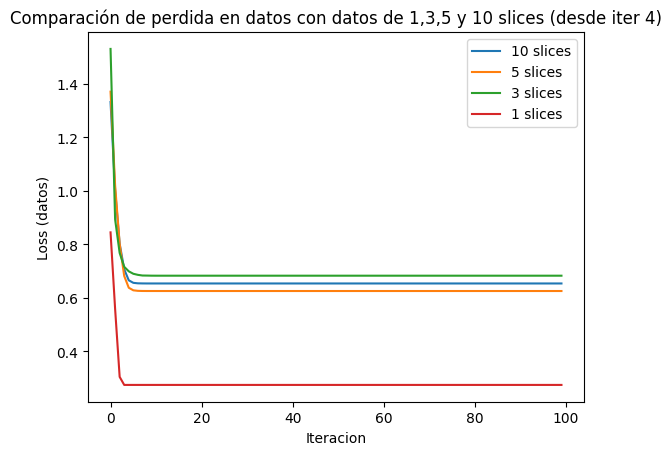

In [ ]:
cut = 0
plt.plot(ran[cut:], loss_rec_ls_10[cut:], label = '10 slices')
plt.plot(ran[cut:], loss_rec_ls_5[cut:], label = '5 slices')
plt.plot(ran[cut:], loss_rec_ls_3[cut:], label = '3 slices')
plt.plot(ran[cut:], loss_rec_ls_1[cut:], label = '1 slices')
plt.title('Comparación de perdida en datos con datos de 1,3,5 y 10 slices (desde iter 4)')
plt.xlabel('Iteracion')
plt.ylabel('Loss (datos)')
plt.legend()
plt.show()